# "Where Is the Love?" (And Can It Be Quantified?): A Network-Topic Discourse Analysis of Romance in Popular Music - Love Song Analysis Script

---
The code in this notebook was created with support from OpenAI's ChatGPT (GPT 4).
Assitance included code drafting and debugging. All final implementation choices and interpretations are my own.

---


## Imports for Song Collection, Word Frequency and Pre-processing Code

In [1]:
import csv
import requests
import pandas as pd
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import string
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import gensim

## Collection of Full Song Lyrics

The full versions of the lyrics used in this project are protected by copyright and therefore cannot be distributed publicly (e.g., on GitHub). Instead, the dataset provided contains irreversibly pre-processed and transformed lyrics, suitable for analysis and compliant with distribution limitations.

However, if you'd like to collect the original full lyrics, the script below demonstrates how this was done using the publicly available lyrics.ovh API.

If you wish to reproduce the full dataset use the provided Python script. Fair warning, this code takes multiple hours to run. 

Please note:
- This API does not guarantee complete or perfectly accurate lyrics and the songs available through this API may have changed since the original data collection in February 2025.
- Your use of the lyrics retrieved from lyrics.ovh should comply with applicable copyright laws and the API provider’s terms of service.

In [ ]:
# Make sure to run the imports cell before running this one.

# ---- Step 1: Read CSV file ----
input_csv = 'FILEPATH_TO_CSV_HERE'  # Replace with your own filepath to run.
songs_df = pd.read_csv(input_csv)

# ---- Step 2: Function to retrieve lyrics ----
def get_lyrics(Song_Title, Artist):   #The csv file used must contain a Song_Title and Artist column to collect songs.
    try:
        time.sleep(0.5)  # Sleep 500ms to use the API respectfully (2 requests/second)
        title = Song_Title.strip()
        artist = Artist.strip()
        response = requests.get(f'https://api.lyrics.ovh/v1/{artist}/{title}')
        response.raise_for_status()
        lyrics = response.json().get('lyrics', None)
        return {'Song_Title': title, 'Artist': artist, 'Lyrics': lyrics}
    except requests.exceptions.RequestException as e:
        print(f"Error for '{title}' by {artist}: {e}")
        return {'Song_Title': Song_Title, 'Artist': Artist, 'Lyrics': None}
        
# ---- Step 3: Collect lyrics ----
results = []
missing = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {
        executor.submit(get_lyrics, row['Song_Title'], row['Artist']): row
        for _, row in songs_df.iterrows()
    }

    # Process the results (either successful collection or missing lyrics)
    for future in tqdm(as_completed(futures), total=len(futures), desc="Collecting lyrics"):
        result = future.result()
        results.append(result)
        if result['Lyrics'] is None:
            missing.append(result)

# ---- Step 4: Save full results ----
lyrics_df = pd.DataFrame(results)
lyrics_df.to_csv('ADD_OUTPUT_FILEPATH_HERE/songs_with_lyrics.csv', index=False)

# ---- Step 5: Save missing songs ----
pd.DataFrame(missing).to_csv('ADD_OUTPUT_FILEPATH_HERE/missing_lyrics.csv', index=False)

# ---- Step 6: Done ----
print("Lyrics saved to your output filepath as songs_with_lyrics.csv")
print("Missing lyrics saved to output filepath as missing_lyrics.csv")



## Lyric Pre-processing

To comply with aforementioned copyright restrictions, the lyrics provided on GitHub are pre-processed and irreversibly transformed, making them unsuitable for reconstruction into their original form.

For full transparency, the pre-processing steps applied to the lyrics are detailed below.

## Identification of highest frequency words (Not for use with provided dataset)

The below code was initially used to identify frequently occurring words in order to construct the stopword list for pre-processing. It was run on the full sets of lyrics.

In [ ]:
# Make sure to run the imports cell before running this one.

# --- Step 1: Setup ---
FILE_PATH = "FILEPATH_TO_CSV_HERE/songs_with_lyrics.csv" # Replace with your own filepath to a csv with lyrics.

# Download NLTK resources if needed
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

stop_words = set(stopwords.words('english')) # Removing stopwords from lyrics to avoid noise.

def clean_lyrics(text):
    # This function makes lowercase, removes punctuation, tokenises, and removes stopwords.
    if pd.isna(text):
        return []
    text = text.lower().translate(str.maketrans("", "", string.punctuation))
    return [word for word in word_tokenize(text) if word not in stop_words]

# --- Step 2: Main Pipeline ---
try:
    df = pd.read_csv(FILE_PATH)
    assert 'Lyrics' in df.columns, "'Lyrics' column not found."
except Exception as e:
    raise SystemExit(f" Error loading file: {e}")

print("Data loaded. Cleaning lyrics and analysing word frequency.")

df["Processed Lyrics"] = df["Lyrics"].apply(clean_lyrics) # Lyrics must be contained in a column called Lyrics.

# Flatten list of all words
all_words = sum(df["Processed Lyrics"], [])

# Get top 50 most common words
word_counts = Counter(all_words).most_common(50)

print("\n Top 50 Most Common Words:")
for word, count in word_counts:
    print(f"{word}: {count}")
    

## Lyric Pre-processing Code (Not for use with provided dataset)

This script performs text preprocessing on full song lyrics to prepare them for analysis. It removes punctuation, stop words (including selected custom ones), and lowers casing. The goal is to create a version of the lyrics that is suitable for NLP tasks and transform them enough to comply with copyright guidelines.

In [1]:
# Make sure to run the imports cell before running this one.

# --- Step 1: Setup ---
# Downloads required NLTK resources for tokenisation and stopwords
nltk.download("punkt")
nltk.download("stopwords")

# Extended stopwords list 
stop_words = stopwords.words('english')
sstop_words.extend([
    # Common contractions and informal words
    "'s", "'ve", "'re", "'m", "'d", "'ll", "ca", "wo", "ill", "don", "doesn", "isn",
    "wan", "gon", "na", "gonna", "wanna", "ya", "im", "cause", "dont", "goin",
   
    # Fillers, exclamations, and interjections often found in lyrics
    "yeah", "uh", "oh", "ah", "yo", "ooh", "woo", "uhh", "hey", "like",
   
    # Common verbs that don't add semantic topic value
    "be", "make", "come", "tell", "put", "take", "go", "let", "give",
    "know", "want", "think", "find", "try", "live", "move",
    "stand", "run", "show", "call", "watch", "hear", "walk",
    "break", "prove", "use", "drive", "turn", "say", "bring",
   
    # Common adjectives and adverbs that may not be topic discriminative
    "really", "well", "good", "even", "still", "little", "something",
    "nothing", "much", "true", "bad", "big", "sweet", "fine", "nice",
    "pretty", "hard", "free", "open", "glad",
   
    # Common prepositions and pronouns
    "out", "in", "on", "off", "around", "through", "there", "here",
  
    # Generic nouns and terms common in songs but less useful for topics
    "thing", "way", "world", "baby", "name", "heart", "day", "night",
    "fire", "money", "people", "place", "word", "friend",
    "town", "color", "wind", "lady", "guy", "time",
    "chorus", "round", "lovin", "swing", "radio", "boogie", "next",
    "train", "minute",
  
    # Temporal and frequency words
     "never", "ever", "long", "old", "young", "past", "present", "future", "sometimes"
])

# Loads spaCy English model, disabling unnecessary pipeline components for efficiency
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Definition of Functions: 

def assign_generation(year):
    # Function assigns generation labels based on release year of the song.
    # Returns "Unknown" if year is missing or invalid.
    if pd.isna(year) or not str(year).isdigit():
        return "Unknown"
    year = int(year)
    if 1965 <= year <= 1980:
        return "Gen X"
    elif 1981 <= year <= 2000:
        return "Millennial"
    elif 2001 <= year <= 2010:
        return "Gen Z"
    elif year >= 2011:
        return "Gen Alpha"
    else:
        return "Unknown"


def clean_lyrics(text):
    # Function cleans raw lyrical text and returns list of cleaned words:
    # Converts to lowercase
    # Removes punctuation
    # Tokenises into words
    # Filters out non-alphabetic tokens and stopwords
    if pd.isna(text): return []
    text = text.lower().translate(str.maketrans("", "", string.punctuation))
    return [word for word in word_tokenize(text) if word.isalpha() and word not in stop_words]


def remove_stopwords(texts):
    # Function removes stopwords from a list of token lists.
    return [[word for word in doc if word not in stop_words] for doc in texts]


def lemmatise(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Function lemmatises tokens using spaCy and keep only specified POS tags 
    # and returns a list of lists with lemmatised tokens.
    output = []
    for doc in texts:
        joined = " ".join(doc)
        doc_out = nlp(joined)
        output.append([token.lemma_ for token in doc_out if token.pos_ in allowed_postags])
    return output

# --- Step 2: Main Pipeline ---

# Load the dataset 
df = pd.read_csv("FILEPATH_TO_CSV_HERE/songs_with_lyrics.csv") # Replace with your own filepath to run.
df["Generation"] = df["Release Year"].apply(assign_generation)

# Filter out songs without known generations
df = df[df["Generation"] != "Unknown"]

# Clean and tokenise lyrics into words
data_words = df["Lyrics"].apply(clean_lyrics).tolist()

# Build bigrams and trigrams models for multi-word expressions commonly found in lyrics
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=120)
trigram = gensim.models.Phrases(bigram[data_words], threshold=120)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Apply bigrams to tokenised data, lemmatise
data_words_bigrams = [bigram_mod[doc] for doc in data_words]
data_lemmatised = lemmatise(data_words_bigrams)

# Remove stopwords again after lemmatisation and phrase detection
data_final = remove_stopwords(data_lemmatised)

# Attach processed lyrics to the final dataset
df["Processed_Tokens"] = data_final
df.to_csv("ADD_OUTPUT_FILEPATH_HERE/processed_songs.csv", index=False)
print("✅ Processed and saved to: processed_songs.csv")


[nltk_data] Downloading package punkt to /Users/madeline/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madeline/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Processed and saved to: processed_lyrics.csv


# Remaining scripts can be run with the dataset provided.
The remainder of the scripts in this project are designed to run directly on the pre-processed dataset provided, in accordance with the usage guidelines outlined in the README on GitHub.

If you'd prefer to run these analyses on your own collected lyrics data, you are welcome to do so,  just make sure to:
- Match or adjust file paths accordingly
- Ensure that column names align with those expected by the scripts

## BERTopic Model
The script was written and executed in a Google Colab notebook to take advantage of faster processing and GPU support. The full script, along with explanatory notes, is available in the accompanying GitHub repository for transparency and reproducibility.

## Topic Model With LDA 
This script evaluates the LDA topic modelling performance across generational cohorts using the processed love song lyrics. The goal is to find the optimal number of topics for each generation by comparing coherence scores.

What the code does:

- Reads the dataset and safely converts preprocessed token strings into Python lists.
- Iterates over each generation (Gen X, Millennials, Gen Z, Gen Alpha) in the dataset.
- For each generation:
    - Constructs a Gensim dictionary and corpus.
    - Trains LDA models over a range of topic counts (2 to 15).
    - Computes the coherence scores (a measure of topic quality) for each configuration.
    - Plots coherence vs. number of topics.
    - Selects the best model based on the highest coherence within a small margin of the best score.
    - Displays the best topics and coherence score. 

You can tailor paths and column names to suit your own dataset if necessary.

In [94]:
# Imports
import pandas as pd
from pprint import pprint
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
from IPython.display import display
import numpy as np
import random
import ast


 Processing generation: Millennial


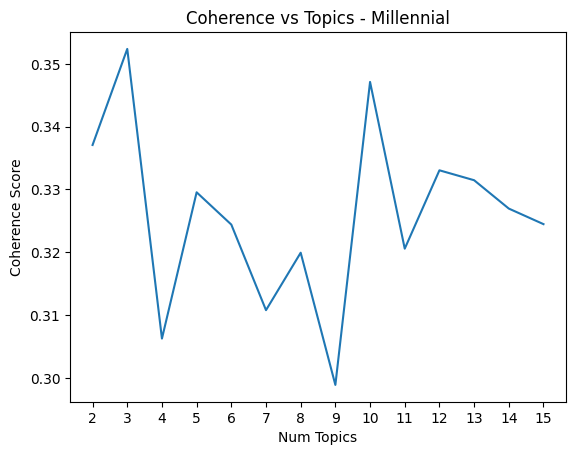


✅ Chose 10 topics (highest within threshold 0.01 of max coherence: 0.3524)
[(0, '0.084*"dance" + 0.077*"play" + 0.034*"hide" + 0.032*"one" + 0.032*"game" + 0.028*"easy" + 0.022*"set" + 0.020*"music" + 0.019*"part" + 0.019*"rise"'), (1, '0.116*"boy" + 0.046*"new" + 0.023*"purple_rain" + 0.021*"wear" + 0.020*"party" + 0.018*"tired" + 0.013*"shoe" + 0.013*"thinkin" + 0.013*"daddy" + 0.012*"wild"'), (2, '0.043*"light" + 0.034*"hit" + 0.024*"car" + 0.024*"last" + 0.020*"kill" + 0.018*"happy" + 0.017*"pay" + 0.017*"shell" + 0.015*"ground" + 0.015*"phone"'), (3, '0.065*"away" + 0.047*"dream" + 0.043*"fall" + 0.038*"kiss" + 0.027*"forever" + 0.026*"wish" + 0.025*"together" + 0.022*"miss" + 0.018*"lonely" + 0.018*"eye"'), (4, '0.090*"hold" + 0.040*"talk" + 0.038*"hurt" + 0.036*"stay" + 0.033*"hand" + 0.032*"enough" + 0.030*"fly" + 0.029*"high" + 0.026*"tear" + 0.026*"door"'), (5, '0.257*"love" + 0.068*"need" + 0.041*"life" + 0.020*"real" + 0.019*"end" + 0.018*"change" + 0.014*"fool" + 0.013*"c

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.141596  0.021804       1        1  20.185605
9     -0.215052  0.054412       2        1  16.634364
6     -0.252758  0.025442       3        1  14.765623
3      0.046210  0.255320       4        1  13.756996
8      0.173536  0.020137       5        1   9.807024
4      0.171654  0.236205       6        1   8.420569
0     -0.064914 -0.208402       7        1   5.303055
2      0.000289 -0.072734       8        1   4.896546
1      0.181399 -0.180855       9        1   3.910427
7      0.101232 -0.151329      10        1   2.319792, topic_info=              Term         Freq        Total Category  logprob  loglift
8             love  6748.000000  6748.000000  Default  30.0000  30.0000
22             get  5048.000000  5048.000000  Default  29.0000  29.0000
21            feel  2292.000000  2292.000000  Default  28.0000  28.0000
98            girl  1


 Processing generation: Gen Z


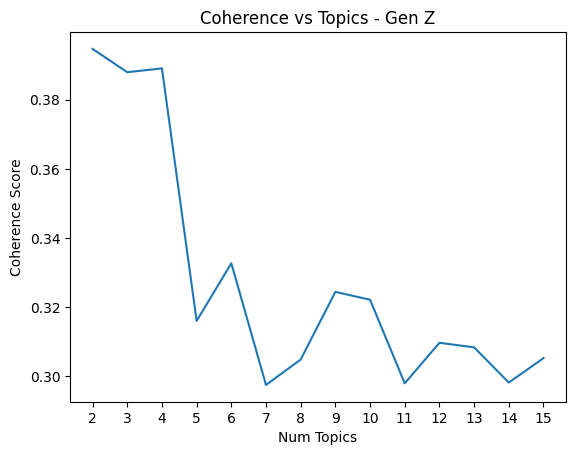


✅ Chose 4 topics (highest within threshold 0.01 of max coherence: 0.3947)
[(0, '0.019*"eye" + 0.016*"dream" + 0.016*"look" + 0.014*"home" + 0.012*"light" + 0.012*"tonight" + 0.012*"hand" + 0.011*"back" + 0.010*"song" + 0.010*"face"'), (1, '0.050*"get" + 0.048*"feel" + 0.034*"need" + 0.028*"keep" + 0.027*"right" + 0.024*"life" + 0.020*"away" + 0.019*"leave" + 0.016*"mind" + 0.016*"wait"'), (2, '0.127*"get" + 0.057*"girl" + 0.022*"boy" + 0.017*"man" + 0.010*"right" + 0.009*"body" + 0.009*"club" + 0.009*"back" + 0.009*"hit" + 0.008*"ready"'), (3, '0.196*"love" + 0.020*"kiss" + 0.018*"cry" + 0.015*"hold" + 0.014*"enough" + 0.013*"lie" + 0.012*"bit" + 0.011*"mine" + 0.010*"die" + 0.009*"chance"')]
Coherence Score: 0.38907807695990243


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.094944  0.328833       1        1  33.432794
1      0.153310 -0.069694       2        1  28.405919
3     -0.302662 -0.192359       3        1  20.266679
2      0.244297 -0.066780       4        1  17.894608, topic_info=      Term          Freq         Total Category  logprob  loglift
10    love  11157.000000  11157.000000  Default  30.0000  30.0000
33     get  10364.000000  10364.000000  Default  29.0000  29.0000
200   girl   2849.000000   2849.000000  Default  28.0000  28.0000
31    feel   4027.000000   4027.000000  Default  27.0000  27.0000
13    need   2709.000000   2709.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
2     back    448.560703   2502.317579   Topic4  -4.7192   0.0017
8     head    324.502712   1295.144906   Topic4  -5.0429   0.3366
696  shake    244.134153    445.765865 


 Processing generation: Gen Alpha


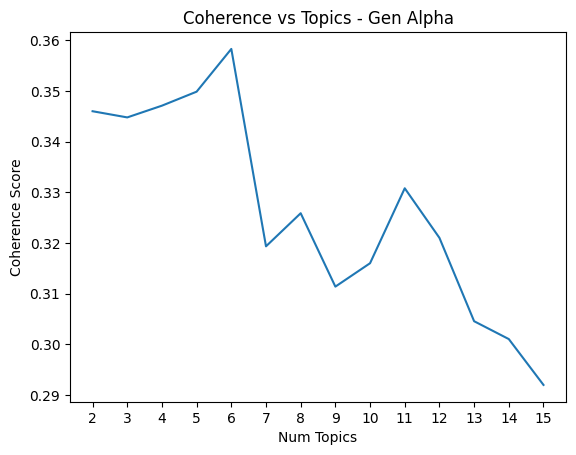


✅ Chose 6 topics (highest within threshold 0.01 of max coherence: 0.3583)
[(0, '0.069*"feel" + 0.048*"need" + 0.030*"keep" + 0.026*"hold" + 0.022*"get" + 0.021*"wait" + 0.020*"fall" + 0.019*"tonight" + 0.017*"kiss" + 0.015*"touch"'), (1, '0.036*"light" + 0.035*"away" + 0.035*"dance" + 0.033*"mind" + 0.025*"body" + 0.025*"stay" + 0.023*"lose" + 0.017*"taste" + 0.016*"fly" + 0.014*"game"'), (2, '0.161*"get" + 0.033*"girl" + 0.024*"fuck" + 0.022*"bitch" + 0.018*"shit" + 0.014*"man" + 0.014*"pull" + 0.013*"boy" + 0.011*"hit" + 0.010*"party"'), (3, '0.115*"back" + 0.088*"look" + 0.068*"right" + 0.037*"work" + 0.027*"crazy" + 0.018*"face" + 0.017*"sleep" + 0.017*"guess" + 0.016*"wake" + 0.014*"sit"'), (4, '0.022*"life" + 0.020*"leave" + 0.015*"lie" + 0.013*"eye" + 0.012*"mean" + 0.012*"dream" + 0.012*"die" + 0.012*"change" + 0.012*"cry" + 0.011*"head"'), (5, '0.521*"love" + 0.025*"trust" + 0.015*"mine" + 0.010*"real" + 0.010*"fall" + 0.009*"fun" + 0.009*"top" + 0.009*"belong" + 0.008*"hate"

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.129176 -0.082878       1        1  28.236340
0      0.076430 -0.004635       2        1  23.332844
2     -0.005641 -0.146530       3        1  20.607261
1      0.101668 -0.174576       4        1  11.911552
3      0.107949  0.377457       5        1   8.115328
5     -0.409581  0.031163       6        1   7.796675, topic_info=      Term         Freq        Total Category  logprob  loglift
24    love  8227.000000  8227.000000  Default  30.0000  30.0000
59     get  8118.000000  8118.000000  Default  29.0000  29.0000
55    feel  3286.000000  3286.000000  Default  28.0000  28.0000
267   back  1892.000000  1892.000000  Default  27.0000  27.0000
121   look  1841.000000  1841.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
113   fall   153.937806  1086.090568   Topic6  -4.6314   0.5977
308   head   


 Processing generation: Gen X


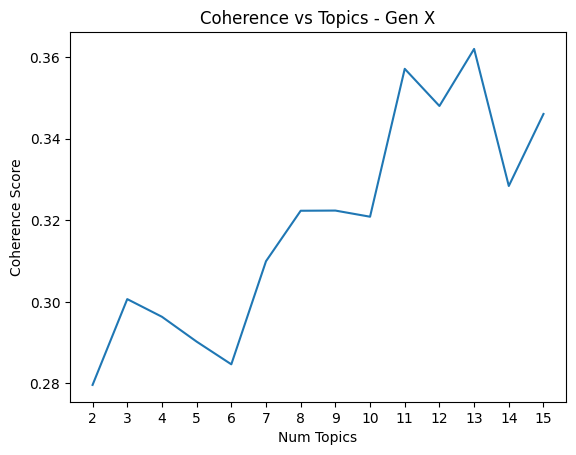


✅ Chose 13 topics (highest within threshold 0.01 of max coherence: 0.3620)
[(0, '0.645*"need" + 0.045*"number" + 0.038*"leave" + 0.028*"left" + 0.025*"rest" + 0.020*"list" + 0.019*"breathe" + 0.014*"air" + 0.012*"pack" + 0.010*"cure"'), (1, '0.173*"tonight" + 0.134*"mine" + 0.108*"line" + 0.097*"remember" + 0.059*"wait" + 0.040*"roll" + 0.038*"fun" + 0.022*"dear" + 0.020*"bar" + 0.018*"pour"'), (2, '0.215*"away" + 0.103*"stop" + 0.071*"sky" + 0.070*"smile" + 0.069*"morning" + 0.051*"face" + 0.034*"happy" + 0.031*"anymore" + 0.023*"leave" + 0.022*"rain"'), (3, '0.072*"man" + 0.049*"woman" + 0.046*"right" + 0.035*"hot" + 0.030*"wonder" + 0.029*"year" + 0.024*"wrong" + 0.024*"head" + 0.020*"last" + 0.019*"child"'), (4, '0.257*"love" + 0.028*"hold" + 0.020*"hand" + 0.017*"leave" + 0.017*"keep" + 0.015*"mind" + 0.015*"start" + 0.014*"lose" + 0.014*"cry" + 0.012*"alone"'), (5, '0.165*"dream" + 0.154*"dance" + 0.062*"far" + 0.037*"beautiful" + 0.032*"dark" + 0.029*"summer" + 0.023*"mother" +

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.132126 -0.111521       1        1  27.391898
9      0.051681 -0.259695       2        1  12.485869
6     -0.243324 -0.088248       3        1  12.150903
3     -0.181265  0.155164       4        1  10.478443
11    -0.236484  0.012757       5        1   9.669194
7      0.003041  0.231527       6        1   7.862851
2      0.150472 -0.042541       7        1   4.375188
5      0.079489  0.165799       8        1   4.141393
12     0.051026 -0.157713       9        1   3.014608
10     0.107443 -0.040177      10        1   2.737621
1      0.097238  0.087410      11        1   2.697747
0      0.151023 -0.001414      12        1   2.065229
8      0.101784  0.048654      13        1   0.929056, topic_info=         Term         Freq        Total Category  logprob  loglift
39        get  2379.000000  2379.000000  Default  30.0000  30.0000
19       love


 Processing generation: Generation
Skipping due to insufficient data.


In [101]:
# Make sure to run the imports cell before running this one.

# --- Step 1: Setup ---
# Function to safely convert string representations of lists back to Python lists.
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

# Setting random seeds for reproducibility in numpy and random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Load the pre-processed dataset containing tokenised lyrics
df = pd.read_csv("FILEPATH_TO_CSV_HERE/processed_love_song_dataset_FINAL.csv") # Replace with your own filepath.

# Convert the string representation of token lists into actual Python lists
df["Processed_Tokens"] = df["Processed_Tokens"].apply(safe_literal_eval)

# Define parametres for topic modelling range (start, end, step)
start_topics = 2
limit_topics = 16
step_topics = 1

# Extract unique generations (e.g., Gen X, Millennial) from the dataset for grouped analysis
generations = df["Generation"].unique()

# This function trains multiple LDA topic models for a range of topic numbers.
# and computes and returns the list of models and their coherence scores.
def compute_coherence(dictionary, corpus, texts):
    model_list, coherence_values = [], []
    for num_topics in range(start_topics, limit_topics, step_topics):
        # Train LDA models with given number of topics
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=SEED,
                                       update_every=1,
                                       chunksize=100,
                                       passes=30,
                                       alpha='auto',
                                       per_word_topics=True)
        model_list.append(model)
        
        # Calculate coherence score for the current model
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

# --- Step 2: Main Pipeline ---
# Iterate through each generation group to perform topic modelling
for generation in generations:
    print(f"\n Processing generation: {generation}")
    subset = df[df["Generation"] == generation]
    texts = subset["Processed_Tokens"].tolist()

    # Create dictionary and corpus for gensim LDA
    id2word = corpora.Dictionary(texts)
    id2word.filter_extremes(no_below=3, no_above=0.7)
    corpus = [id2word.doc2bow(text) for text in texts]

    # Skip groups with too little data to model effectively
    if len(corpus) < 20 or len(id2word) < start_topics * 2:
        print("Skipping due to insufficient data.")
        continue

    # Train LDA models and compute coherence scores for each topic number
    model_list, coherence_scores = compute_coherence(id2word, corpus, texts)

    # Plot coherence scores against the number of topics for visualisation
    x = range(start_topics, limit_topics, step_topics)
    plt.plot(x, coherence_scores)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence Score")
    plt.title(f"Coherence vs Topics - {generation}")
    plt.xticks(x)
    plt.show()

    # Select the best model based on coherence score threshold (within 0.01 of max)
    threshold = 0.01 # Adjustable threshold for near-max coherence
    max_coh = max(coherence_scores)
    close_idxs = [i for i, coh in enumerate(coherence_scores) if (max_coh - coh) <= threshold]

    # Choose the model with the most topics within the threshold
    optimal_num_topics = x[max(close_idxs)]
    best_model = model_list[max(close_idxs)]
    best_coherence_score = coherence_scores[close_idxs[-1]]
    print(f"\n✅ Chose {optimal_num_topics} topics (highest within threshold {threshold:.2f} of max coherence: {max_coh:.4f})")

    # Print the top words per topic for interpretation
    print(best_model.print_topics())

    # Compute and print final coherence score for the chosen model
    final_coherence = CoherenceModel(model=best_model, texts=texts, dictionary=id2word, coherence='c_v').get_coherence()
    print(f"Coherence Score: {final_coherence}")

    # Visualise the topic model using pyLDAvis
    try:
        vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
        display(vis) # Display interactive visualisation in Jupyter Notebook
    except:
        pyLDAvis.save_html(vis, f"lda_{generation}.html")# If display fails (e.g., does not display in notebook), save visualisation as HTML file.



## Data Familiarisation: Vocab Overlap and Song Genre/Generation Distribution

This script analyses the song dataset to provide insights into generational vocabulary similarity and genre distribution across generations.

Key features include:
- Loading the dataset
- Assigning songs to generations based on release year (if 'Generation' column not present)
- Computing vocabulary overlap between generations using the Jaccard Index
- Visualising vocabulary overlap as a heatmap
- Summarising song counts by generation
- Plotting song counts by genre and generation

Before running:
- Update the LYRICS_FILE path to point to the processed dataset CSV file
- Ensure the dataset used contains at least the following columns (all present in the dataset provided):
    - 'Processed_Tokens': list of cleaned tokens per song
    - 'Release Year': year the song was released
    - 'Standardised Genre': genre label for the song
      
This script skips tokenisation and lemmatisation since it uses the preprocessed lyric tokens within the dataset.


In [107]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ast

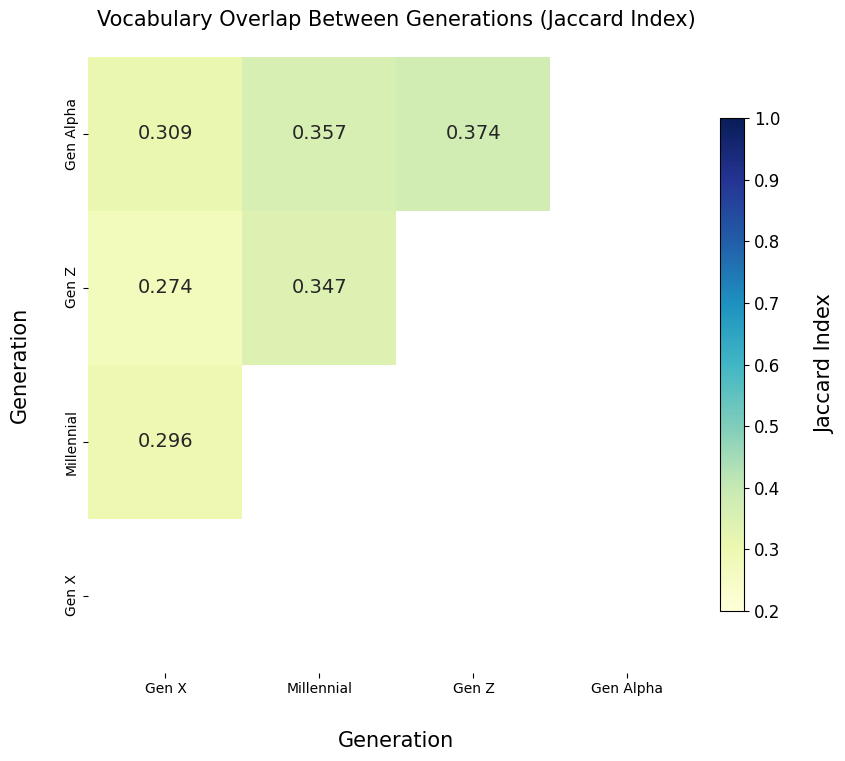


--- Song Counts by Generation ---
Gen X: 1147 songs
Millennial: 2511 songs
Gen Z: 4715 songs
Gen Alpha: 2860 songs


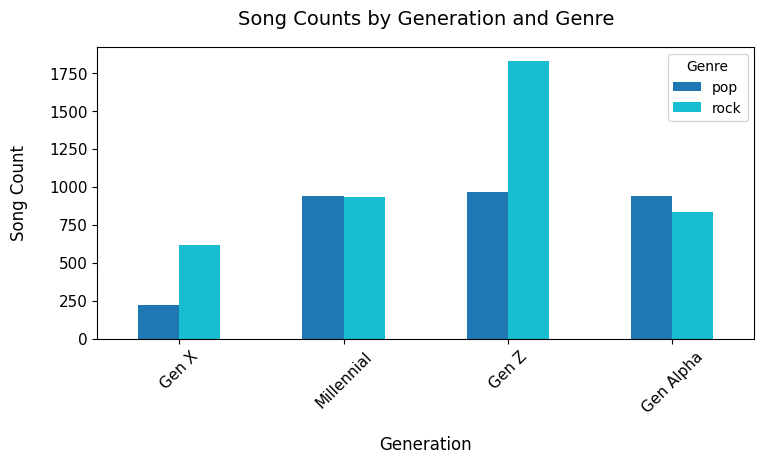


Plots displayed successfully.


In [123]:
# Make sure to run the imports cell before running this one.

# --- Step 1: Setup ---
LYRICS_FILE = "FILEPATH_TO_CSV_HERE/processed_love_song_dataset_FINAL.csv"

# Function assigns generation label based on release year
def assign_generation(year):
    if pd.isna(year) or not str(year).isdigit():
        return "Unknown"
    year = int(year)
    if 1965 <= year <= 1980: return "Gen X"
    elif 1981 <= year <= 2000: return "Millennial"
    elif 2001 <= year <= 2010: return "Gen Z"
    elif year >= 2011: return "Gen Alpha"
    return "Unknown"

# function converts stringified token lists back into Python lists safely
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

# --- Step 2: Load Lyrics Data ---

df_lyrics = pd.read_csv(LYRICS_FILE)
if "Processed_Tokens" not in df_lyrics.columns or "Release Year" not in df_lyrics.columns:
    raise KeyError("Lyrics file must contain 'Processed_Tokens' and 'Release Year'.")

df_lyrics["Processed_Tokens"] = df_lyrics["Processed_Tokens"].apply(safe_literal_eval)
df_lyrics["Generation"] = df_lyrics["Release Year"].apply(assign_generation)
df_lyrics = df_lyrics[df_lyrics["Generation"] != "Unknown"].copy()
df_lyrics["Lemmatised_Lyrics"] = df_lyrics["Processed_Tokens"]  # Reuses processed tokens directly

# --- Step 3: Vocabulary by Generation  ---

generation_order = ["Gen X", "Millennial", "Gen Z", "Gen Alpha"] #chronological
generation_vocab = {}
for gen in generation_order:
    words = df_lyrics[df_lyrics["Generation"] == gen]["Lemmatised_Lyrics"].explode().dropna()
    generation_vocab[gen] = set(words)

# --- Step 4: Jaccard Overlap Matrix Creation ---

overlap_matrix = pd.DataFrame(np.eye(len(generation_order)), index=generation_order, columns=generation_order)

# Compute Jaccard Index between vocabulary sets of each generation
for i, g1 in enumerate(generation_order):
    for j, g2 in enumerate(generation_order):
        if g1 not in generation_vocab or g2 not in generation_vocab:
            overlap_matrix.loc[g1, g2] = 0
            continue
        if i == j:
            overlap_matrix.loc[g1, g2] = len(generation_vocab[g1])
        else:
            inter = generation_vocab[g1] & generation_vocab[g2]
            union = generation_vocab[g1] | generation_vocab[g2]
            jaccard = len(inter) / len(union) if union else 0
            overlap_matrix.loc[g1, g2] = round(jaccard, 4)

# --- Step 5: Heatmap: Vocabulary Overlap Visualisation ---

fig, ax = plt.subplots(figsize=(8, 8))

# Create upper triangle mask
mask = np.triu(np.ones_like(overlap_matrix, dtype=bool))

# Draw the heatmap without colorbar first
sns.heatmap(
    overlap_matrix,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    square=True,
    vmin=0.2,
    vmax=1.0,
    mask=mask,
    ax=ax,
    annot_kws={"size": 14},
    cbar=False,  # We'll add our own colorbar
)

# Create a shorter colorbar axis
pos = ax.get_position()
cbar_height = 0.8
cbar_y0 = pos.y0 + (pos.height * (1 - cbar_height) / 2)
cbar_ax = fig.add_axes([pos.x1 + 0.02, cbar_y0, 0.03, pos.height * cbar_height])

# Add the colorbar
norm = mpl.colors.Normalize(vmin=0.2, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("Jaccard Index", fontsize=15, labelpad=25)
cbar_ax.tick_params(labelsize=12)

# Reverse y-axis for bottom-to-top order
ax.invert_yaxis()

ax.set_xlabel("Generation", fontsize=15, labelpad=25)
ax.set_ylabel("Generation", fontsize=15, labelpad=25)
ax.set_title("Vocabulary Overlap Between Generations (Jaccard Index)", fontsize=15, pad=22)

plt.show()

# --- Step 6: Print SOng Counnts by Generation ---

print("\n--- Song Counts by Generation ---")
song_counts = df_lyrics["Generation"].value_counts().reindex(generation_order).dropna()
for gen, count in song_counts.items():
    print(f"{gen}: {count} songs")

# --- Step 7: Genre Distributino Bar Graph ---    

df_lyrics["Genre"] = df_lyrics["Standardised Genre"].str.lower().str.strip()
target_genres = ["pop", "rock", "pop rock"]
df_filtered = df_lyrics[df_lyrics["Genre"].isin(target_genres)]

song_counts_genre = df_filtered.groupby(["Generation", "Genre"]).size().reset_index(name="Song Count")
pivot_df = song_counts_genre.pivot(index="Generation", columns="Genre", values="Song Count").fillna(0)
pivot_df = pivot_df.reindex(generation_order).fillna(0)
pivot_df = pivot_df.apply(pd.to_numeric, errors="coerce").fillna(0)

if pivot_df.empty or not pivot_df.select_dtypes(include=[np.number]).any().any():
    print("Warning: No valid numeric data available for plotting song counts.")
else:
    ax = pivot_df.plot(kind="bar", stacked=False, figsize=(8, 5), colormap="tab10")
    plt.ylabel("Song Count", fontsize=12, labelpad=15)
    plt.xlabel("Generation", fontsize=12, labelpad=15)
    plt.title("Song Counts by Generation and Genre", fontsize=14, pad=16)
    plt.xticks(rotation=45, fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout(pad=2.0)
    plt.show()

print("\nPlots displayed successfully.")


## Co-Creator Network Visualisation by Generation
This script builds and visualises co-credit networks of songwriters (including performing artists) and producers across different generational cohorts.
It uses collaboration data (writer/producer credits) from a dataset of love songs to:
- Clean and normalise artist names
- Assign songs to generational cohorts (Gen X, Millennial, Gen Z, Gen Alpha)
- Build undirected networks of co-creators
- Plot an overview network (up to 500 nodes sampled by degree)
- Plot a detailed graph of top co-creators per generation

Make sure to update file_path to point to your local dataset.
Your dataset must contain the columns: 'Writers', 'Producers', and 'Release Year'

**Please note**: the network graphs produced may be oriented differently to those in the manuscript, however, they are otherwise identical.

In [ ]:
# Required installs
pip install adjustText
pip install unidecode

In [ ]:
# Imports
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
from unidecode import unidecode

# --- Step 1: Setup ---
NUM_TOP_NODES_DETAILED_GRAPH = 30
NODE_SIZE_MULTIPLIER_OVERVIEW = 50
NODE_SIZE_MULTIPLIER_DETAILED = 200
MIN_DEGREE_THRESHOLD = 2
MAX_NODES_OVERVIEW = 500
LAYOUT_K = 0.3
GLOBAL_MIN_DEGREE = 0
GLOBAL_MAX_DEGREE = 200
NORMALISATION_SEED = 42 # For reproducibility

# Update this to navigate to your local path
file_path = "FILEPATH_TO_CSV_HERE/processed_love_song_dataset_FINAL.csv"  # Replace with your actual file path

# This function loads dataset safely 
try:
    df = pd.read_csv(file_path)
    print(f" Loaded data from filepath")
except FileNotFoundError:
    print(f"❌ Error: File not found at {file_path}")
    exit()

# Cleaning and Normalisation
COMMON_EXCLUDE = {
    "unknown", "n/a", "none", "various artists", "see notes", "and", "jr", "producer", "writer",
    "feat", "featuring", "ft", "with", "lead", "background", "solo", "group"
}

# Filter tokens that are too short, numeric, or common stop words
def is_invalid_token(token):
    token = token.strip().lower()
    return token in COMMON_EXCLUDE or token.isdigit() or len(token) < 3

# Standard name mapping for Beyoncé (appeared in many forms)
NAME_MAP = {
    "beyonce": "beyoncé",
    "beyonce knowles": "beyoncé",
    "beyoncé knowles": "beyoncé"
}

# This function standardises names for consistency
def normalise_name(name):
    name = unidecode(name.lower().strip())
    name = re.sub(r'\s+', ' ', name)
    name = re.sub(r'[^a-z0-9\- ]', '', name)
    return NAME_MAP.get(name, name.title())

# This function cleans format and removes punctuation
def clean_entries(entry):
    if pd.isna(entry):
        return None
    entry_str = str(entry).strip().strip(',')
    entry_str = re.sub(r'\(.*?\)', '', entry_str)
    entry_str = re.sub(r'[,]+', ',', entry_str)
    entry_str = re.sub(r'[^a-zA-Z0-9,\- ]', '', entry_str)
    entry_str = re.sub(r'\s+', ' ', entry_str)
    return entry_str.strip() if entry_str else None

# --- Step 2: Data Cleaning ---
# Applies cleaning and drops rows without required credits
df['Writers'] = df['Writers'].apply(clean_entries)
df['Producers'] = df['Producers'].apply(clean_entries)
df = df.dropna(subset=['Writers', 'Producers'])

# Ensures normalisation is applied reproducibly
np.random.seed(NORMALISATION_SEED)

# Applies normalisation across writer and producer columns
for col in ['Writers', 'Producers']:
    df[col] = df[col].apply(lambda x: ','.join([normalise_name(p.strip()) for p in x.split(',') if not is_invalid_token(p)]))

# This function assigns each song to a generation based on year
def assign_generation(year):
    if pd.isna(year) or not isinstance(year, (int, float)) or year < 1900:
        return "Unknown"
    year = int(year)
    if 1965 <= year <= 1980:
        return "Gen X"
    elif 1981 <= year <= 2000:
        return "Millennial"
    elif 2001 <= year <= 2010:
        return "Gen Z"
    elif year >= 2011:
        return "Gen Alpha"
    return "Other"

df['Generation'] = df['Release Year'].apply(assign_generation)

# --- Step 3: Edge Construction ---
# Creates edges from pairs of people co-credited on the same song
def create_combined_edges(sub_df):
    edges = []
    for _, row in sub_df.iterrows():
        writers = [p.strip() for p in str(row["Writers"]).split(',') if p.strip()]
        producers = [p.strip() for p in str(row["Producers"]).split(',') if p.strip()]
        people = list(set(writers + producers))
        if len(people) > 1:
            edges += [(people[i], people[j]) for i in range(len(people)) for j in range(i + 1, len(people))]
    return edges

# --- Step 4: Create Network Visualisation Functions ---
# Overview network creation using top N nodes sampled by degree
def plot_overview_network(G, title):
    if not G.nodes(): return

    degrees = dict(G.degree())
    nodes = list(G.nodes())

    # Degree-weighted sampling because network is so large
    if len(nodes) > MAX_NODES_OVERVIEW:
        degrees_all = np.array([G.degree(n) for n in nodes], dtype=np.float64)
        degree_probs = degrees_all / degrees_all.sum()
        sampled_nodes = np.random.choice(nodes, size=MAX_NODES_OVERVIEW, replace=False, p=degree_probs)
    else:
        sampled_nodes = nodes

    G = G.subgraph(sampled_nodes).copy()
    degrees = dict(G.degree())

    node_sizes = [NODE_SIZE_MULTIPLIER_OVERVIEW * np.log1p(degrees[n]) for n in G.nodes()]
    node_colours = [degrees[n] for n in G.nodes()]
    pos = nx.spring_layout(G, k=LAYOUT_K, iterations=100, seed=NORMALISATION_SEED)

    fig, ax = plt.subplots(figsize=(18, 14))
    cmap = plt.cm.viridis_r

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colours, cmap=cmap, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color="lightgrey", width=0.3, alpha=0.4, ax=ax)

    plt.title(f"{title} - Overview (Node Size/Colour by Degree)", fontsize=20)
    plt.axis('off')

    # Adds colorbar for node degree
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=GLOBAL_MIN_DEGREE, vmax=GLOBAL_MAX_DEGREE))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.08)
    cbar.set_label('Node Degree', fontsize=14, labelpad=50)

    plt.tight_layout()
    plt.show()

# Detailed network for top collaborators
def plot_detailed_network(G, title, num_top_nodes):
    if not G.nodes(): return

    top_nodes_by_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)[:num_top_nodes]
    subgraph = G.subgraph([n for n, _ in top_nodes_by_degree]).copy()
    degrees = dict(G.degree())

    if not nx.is_connected(subgraph):
        components = sorted(nx.connected_components(subgraph), key=len, reverse=True)
        print(f" {title}: {len(components)} connected components")
        print(f" Component sizes: {[len(c) for c in components]}")

    node_sizes = [NODE_SIZE_MULTIPLIER_DETAILED * np.log1p(degrees[n]) for n in subgraph.nodes()]
    node_colours = [degrees[n] for n in subgraph.nodes()]
    pos = nx.kamada_kawai_layout(subgraph)

    fig, ax = plt.subplots(figsize=(16, 12))
    cmap = plt.cm.plasma_r

    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colours, cmap=cmap, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(subgraph, pos, edge_color="grey", width=0.7, alpha=0.8, ax=ax)
    from adjustText import adjust_text

    # Draw node labels with auto-adjustment
    texts = []
    for node, (x, y) in pos.items():
        texts.append(ax.text(x, y, node, fontsize=20, weight='normal'))

    # Labels key nodes with overlap-aware placement
    adjust_text(
        texts,
        expand_points=(1.2, 1.2),
        arrowprops=dict(arrowstyle='-', color='grey', lw=0.5),
        ax=ax
    )

    plt.title(f"{title} - Top {num_top_nodes} Co-Creators", fontsize=18)
    plt.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=GLOBAL_MIN_DEGREE, vmax=GLOBAL_MAX_DEGREE))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.08)
    cbar.set_label('Node Degree', fontsize=14, labelpad=50)

    plt.tight_layout()
    plt.show()

# --- Step 5: Main Loop: Processing Networks by Generation ---
generations_to_process = ['Gen X', 'Millennial', 'Gen Z', 'Gen Alpha']

for gen in generations_to_process:
    print(f"\n Processing {gen}...")
    sub_df = df[df['Generation'] == gen]
    if sub_df.empty:
        print(f"⚠ No data for {gen}")
        continue

    edges = create_combined_edges(sub_df)
    if not edges:
        print(f"⚠ No edges for {gen}")
        continue

    G = nx.Graph()
    G.add_edges_from(edges)
    initial_nodes = G.number_of_nodes()

    # Filter out nodes with very low collaboration counts
    nodes_to_remove = [n for n in G.nodes if G.degree(n) < MIN_DEGREE_THRESHOLD]
    G.remove_nodes_from(nodes_to_remove)

    print(f" Cleaned: {initial_nodes} → {G.number_of_nodes()} nodes")

    plot_overview_network(G.copy(), f"Co-Credit Network - {gen}")
    top_n = NUM_TOP_NODES_DETAILED_GRAPH if G.number_of_nodes() > NUM_TOP_NODES_DETAILED_GRAPH else G.number_of_nodes()
    plot_detailed_network(G.copy(), f"Co-Credit Network - {gen}", top_n)

print("\n All generation networks processed and visualised.")


## Degree Distribution Analysis for Co-Credit Networks

This script analyses the degree distributions of collaboration networks built from writer and producer data from the provided dataset. It determines whether the networks follow a power-law distribution, which is common in social and creative networks.

Each network represents co-credit relationships (writers & producers) for songs grouped by generation.

Key steps:
- Build the co-credit network by connecting artists who collaborated
- Compute the degree distribution
- Fit and compare power-law models with exponential and log-normal alternatives

NOTE: Update the file_path variable to the location of your CSV file before running.

In [ ]:
pip install powerlaw

In [160]:
# --- Imports ---
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
import re 

# --- Step 1: Configuration for data loading and cleaning ---
file_path = "FILEPATH_TO_CSV_HERE/processed_love_song_dataset_FINAL" # Update this path with your own.

# Same as above 
# This function creates co-credit edges
def create_combined_edges(sub_df):
    edges = []
    for _, row in sub_df.iterrows():
        writers = [p.strip() for p in str(row["Writers"]).split(',') if p.strip()]
        producers = [p.strip() for p in str(row["Producers"]).split(',') if p.strip()]
        people = list(set(writers + producers))
        if len(people) > 1:
            edges += [(people[i], people[j]) for i in range(len(people)) for j in range(i + 1, len(people))]
    return edges


# This function analyses the degree distribution of the network,
# and tests for power-law fit.   
def analyse_degree_distribution(edges, title, min_degree_threshold=2):
    G = nx.Graph()
    G.add_edges_from(edges)
    
    # Filter out nodes with degree less than min_degree_threshold for analysis
    initial_nodes_count = G.number_of_nodes()
    nodes_to_remove = [n for n in G.nodes if G.degree(n) < min_degree_threshold]
    G.remove_nodes_from(nodes_to_remove)
    print(f"  For {title}: Removed {len(nodes_to_remove)} nodes with degree less than {min_degree_threshold} (from {initial_nodes_count} to {G.number_of_nodes()}).")

    if not G.nodes():
        print(f"  Warning: No nodes remaining for {title} after filtering. Skipping degree distribution analysis.")
        return

    degrees = np.array([G.degree(n) for n in G.nodes])
    
    if len(degrees) == 0:
        print(f"  Warning: No degrees to analyse for {title}. Skipping degree distribution analysis.")
        return
    
    # --- Fit power-law ---
    if len(np.unique(degrees)) < 2:
        print(f"  Warning: Not enough unique degrees ({len(np.unique(degrees))}) for {title} to perform power-law fit. Skipping.")
        return

    try:
        fit = powerlaw.Fit(degrees, discrete=True) 
        
        # --- Compare with other distributions ---
        results_exp = fit.distribution_compare('power_law', 'exponential')
        print(f"  {title} - Power-law vs Exponential: Log-likelihood Ratio = {results_exp[0]:.2f}, p-value = {results_exp[1]:.4f}")
        
        results_lognorm = fit.distribution_compare('power_law', 'lognormal')
        print(f"  {title} - Power-law vs Lognormal: Log-likelihood Ratio = {results_lognorm[0]:.2f}, p-value = {results_lognorm[1]:.4f}")
    except Exception as e:
        print(f"  Error during power-law fitting for {title}: {e}")

# --- Run for each generation ---
generations_to_process = ['Gen X', 'Millennial', 'Gen Z', 'Gen Alpha']
MIN_DEGREE_THRESHOLD_FOR_ANALYSIS = 2 # Uses the same threshold as for the network analysis

print("\n--- Starting Degree Distribution Analysis for Each Generation ---")
for gen in generations_to_process:
    print(f"\nProcessing degree distribution for {gen}...")
    sub_df = df[df['Generation'] == gen]

    if sub_df.empty:
        print(f"  No data available for {gen} generation. Skipping.")
        continue

    # Creates all possible co-credit edges for the current generation
    combined_edges = create_combined_edges(sub_df)

    if not combined_edges:
        print(f"  No co-credit relationships found for {gen} generation. Skipping degree distribution analysis.")
        continue

    # Applies the degree distribution analysis to the edges
    analyse_degree_distribution(combined_edges, f"Co-Credit Network - {gen}", MIN_DEGREE_THRESHOLD_FOR_ANALYSIS)

# Print results
print("\nDegree distribution analyses complete for all specified generations.")




--- Starting Degree Distribution Analysis for Each Generation ---

Processing degree distribution for Gen X...
  For Co-Credit Network - Gen X: Removed 261 nodes with degree less than 2 (from 1171 to 910).
Calculating best minimal value for power law fit
  Co-Credit Network - Gen X - Power-law vs Exponential: Log-likelihood Ratio = -4.36, p-value = 0.0274
  Co-Credit Network - Gen X - Power-law vs Lognormal: Log-likelihood Ratio = -3.65, p-value = 0.0353

Processing degree distribution for Millennial...


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


  For Co-Credit Network - Millennial: Removed 379 nodes with degree less than 2 (from 2847 to 2468).
Calculating best minimal value for power law fit
  Co-Credit Network - Millennial - Power-law vs Exponential: Log-likelihood Ratio = 53.36, p-value = 0.0010
  Co-Credit Network - Millennial - Power-law vs Lognormal: Log-likelihood Ratio = -13.27, p-value = 0.0003

Processing degree distribution for Gen Z...
  For Co-Credit Network - Gen Z: Removed 446 nodes with degree less than 2 (from 4275 to 3829).
Calculating best minimal value for power law fit
  Co-Credit Network - Gen Z - Power-law vs Exponential: Log-likelihood Ratio = 102.36, p-value = 0.0002
  Co-Credit Network - Gen Z - Power-law vs Lognormal: Log-likelihood Ratio = -35.78, p-value = 0.0000

Processing degree distribution for Gen Alpha...
  For Co-Credit Network - Gen Alpha: Removed 266 nodes with degree less than 2 (from 4431 to 4165).
Calculating best minimal value for power law fit
  Co-Credit Network - Gen Alpha - Power-l

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
